<a href="https://kritikseth.github.io/ipynbtagredirect" target="_parent"><img src="https://raw.githack.com/kritikseth/kritikseth/master/assets/icons/kritik_ipynbtagredirect.svg" alt="Kritik Seth"/></a>

<h1 style="background-color:#2d6187;color:white;font-family:Arial;font-size:350%;text-align:center">Arabic Letters</h1>

In [1]:
!wget -O 'train.csv' 'http://upscfever.com/datasets/csvTrainImages13440x1024.csv' -P drive/app -q
!wget -O 'train_labels.csv' 'http://upscfever.com/datasets/csvTrainLabel13440x1.csv' -P drive/app -q
!wget -O 'test.csv' 'http://upscfever.com/datasets/csvTestImages3360x1024.csv' -P drive/app -q
!wget -O 'test_labels.csv' 'http://upscfever.com/datasets/csvTestLabel3360x1.csv' -P drive/app -q

In [2]:
import pandas as pd
import numpy as np

import os
import cv2
from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [3]:
def plot_train_val_metrics(history):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Accuracy', 'Loss'))

    fig.add_trace(go.Scatter(y=history.history['acc'],
                            mode='lines',
                            name='Train',
                            marker_color='#ff414d',
                            opacity=0.75),
                row=1, col=1)

    fig.add_trace(go.Scatter(y=history.history['val_acc'],
                            mode='lines',
                            name='Validation',
                            marker_color='#1f4068',
                            opacity=0.75),
                row=1, col=1)

    fig.add_trace(go.Scatter(y=history.history['loss'],
                            mode='lines',
                            name='Train',
                            marker_color='#ff414d',
                            opacity=0.75),
                row=1, col=2)
    fig.add_trace(go.Scatter(y=history.history['val_loss'],
                            mode='lines',
                            name='Validation',
                            marker_color='#1f4068',
                            opacity=0.75),
                row=1, col=2)

    fig.show()

In [4]:
train = pd.read_csv('train.csv', header=None)
train_labels = pd.read_csv('train_labels.csv', header=None)
test = pd.read_csv('test.csv', header=None)
test_labels = pd.read_csv('test_labels.csv', header=None)

In [5]:
train_labels[0] -= 1
test_labels[0] -= 1

In [6]:
def save_to_dir(df, labels, folder_name):
    label = 0
    for img in df.values:
        img = img.reshape(32, 32)
        cv2.imwrite(f'{folder_name}/{labels.iloc[label, 0]}_{label}.jpg', img)
        label += 1

In [7]:
!mkdir 'Arabic Letters'
!mkdir 'Arabic Letters/Train'
!mkdir 'Arabic Letters/Test'

In [8]:
save_to_dir(train, train_labels, '/content/Arabic Letters/Train')
save_to_dir(test, test_labels, '/content/Arabic Letters/Test')

In [9]:
def make_dataframe(folder_path):
    img_list = os.listdir(folder_path)
    df = pd.DataFrame(columns=['Path', 'Label'])
    for img in img_list:
        df = df.append({'Path': folder_path+'/'+img,
                        'Label': img.split('_')[0]},
                        ignore_index=True)
    return df

In [10]:
train_df = make_dataframe('/content/Arabic Letters/Train')
test_df = make_dataframe('/content/Arabic Letters/Test')

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=10,
                                   zoom_range=0.10,
                                   width_shift_range=0.10,
                                   height_shift_range=0.10,
                                   shear_range=0.10,
                                   fill_mode='nearest',
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [13]:
batch_size = 50
img_rows, img_cols = (32, 32)
input_shape = (img_rows, img_cols, 3)
dir = ''

train_aug = train_datagen.flow_from_dataframe(dataframe=train_df,
                                              directory=dir,
                                              x_col='Path',
                                              y_col='Label',
                                              batch_size=batch_size,
                                              target_size=(img_rows, img_cols),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=False,
                                              color_mode='rgb',
                                              seed=123)

valid_aug = train_datagen.flow_from_dataframe(dataframe=train_df,
                                              directory=dir,
                                              x_col='Path',
                                              y_col='Label',
                                              batch_size=batch_size,
                                              target_size=(img_rows, img_cols),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False,
                                              color_mode='rgb',
                                              seed=123)

test_aug = test_datagen.flow_from_dataframe(dataframe=test_df,
                                            directory=dir,
                                            x_col='Path',
                                            y_col='Label',
                                            batch_size=batch_size,
                                            target_size=(img_rows, img_cols),
                                            class_mode='categorical',
                                            shuffle=False,
                                            color_mode='rgb')

Found 10752 validated image filenames belonging to 28 classes.
Found 2688 validated image filenames belonging to 28 classes.
Found 3360 validated image filenames belonging to 28 classes.


In [14]:
import keras
import tensorflow as tf
from tqdm.keras import TqdmCallback

In [15]:
train_labels = keras.utils.to_categorical(train_df['Label'])

# Feed Forward Networks (ANN)

In [16]:
ann = keras.models.Sequential()

ann.add(keras.layers.Flatten(input_shape=input_shape))
ann.add(keras.layers.Dense(units=1024, activation='relu'))
ann.add(keras.layers.Dense(units=512, activation='relu'))
ann.add(keras.layers.Dense(units=256, activation='relu'))
ann.add(keras.layers.Dense(units=256, activation='relu'))
ann.add(keras.layers.Dense(units=28, activation='softmax'))

ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 28)                7196      
Total params: 3,875,868
Trainable params: 3,875,868
Non-trainable params: 0
______________________________________________

In [17]:
ch = tf.keras.callbacks.ModelCheckpoint(
    filepath='ann.hdf5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.003,
    patience=15,
    mode='max',
    restore_best_weights=True,
)

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.005,
    patience=3,
    mode='max',
)

In [18]:
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [19]:
history = ann.fit(train_aug, validation_data=valid_aug, epochs=50, verbose=0,
                    callbacks=[ch, es, lr, TqdmCallback(verbose=1)])

In [20]:
ann.evaluate(test_aug)

68/68 [==============================] - 1s 12ms/step - loss: 0.3015 - acc: 0.8985


[0.3014741539955139, 0.8985118865966797]

### Accuracy Screenshot- 0.9015


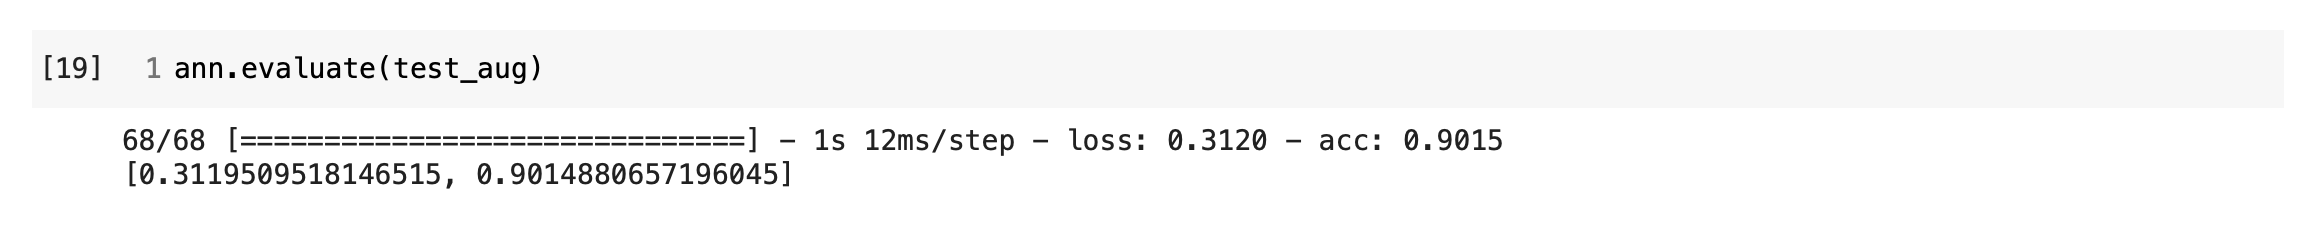

### Training vs Validation 

**Accuracy vs Loss** Plots

In [21]:
plot_train_val_metrics(history)

In [22]:
del history

# Convolutional Neural Network

In [23]:
cnn = keras.models.Sequential()

cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=input_shape))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
cnn.add(keras.layers.BatchNormalization())

cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(keras.layers.BatchNormalization())

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(units=256, activation='relu'))
cnn.add(keras.layers.Dense(units=128, activation='relu'))
cnn.add(keras.layers.Dropout(0.3))

cnn.add(keras.layers.Dense(units=28, activation='softmax'))

In [24]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [25]:
ch = tf.keras.callbacks.ModelCheckpoint(
    filepath='ann.hdf5',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.003,
    patience=15,
    mode='max',
    restore_best_weights=True,
)

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.005,
    patience=3,
    mode='max',
)

In [26]:
history = cnn.fit(train_aug, validation_data=valid_aug, epochs=50, verbose=0,
                    callbacks=[ch, es, lr, TqdmCallback(verbose=1)])

In [27]:
cnn.evaluate(test_aug)

68/68 [==============================] - 1s 13ms/step - loss: 0.1047 - acc: 0.9750


[0.10473135858774185, 0.9750000238418579]

### Accuracy Screenshot- 0.9829
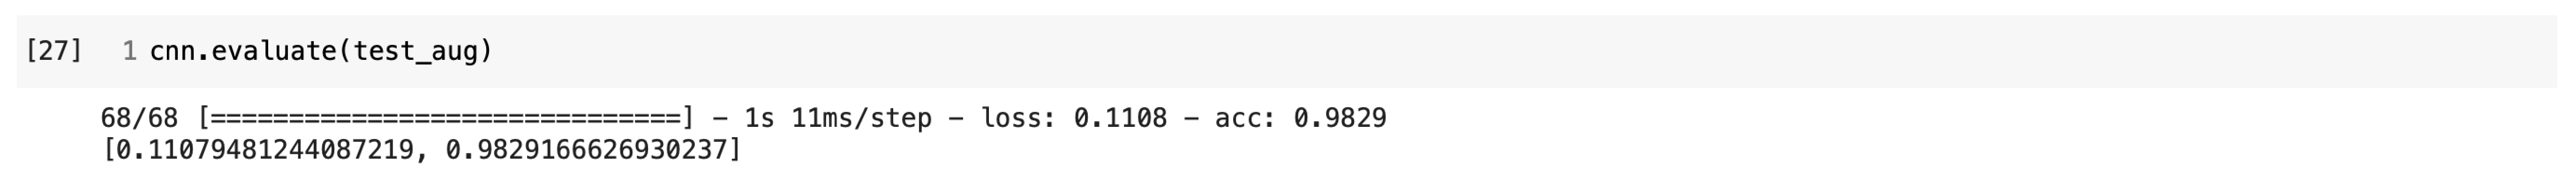

### Training vs Validation 

**Accuracy vs Loss** Plots

In [28]:
plot_train_val_metrics(history)

<h1 style="background-color:#2d6187;color:white;font-family:Arial;font-size:350%;text-align:center">Flower Classification</h1>